# Credible set size quality controls

The goal of the analusis is to check the distribution of the credible set sizes

- across the major ancestry groups
- across study types


## Data Loading

The data required for this analysis is loaded from the `computed maf` dataset.


In [1]:
import plotnine as p9
from gentropy.common.session import Session

from manuscript_methods import OpenTargetsTheme, aggregated_statistics, plot_aggregated_data
from manuscript_methods.datasets import LeadVariantEffect


python(88398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead_variant_effect"


python(88463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 13:53:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/03 13:53:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/03 13:53:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/07/03 13:53:29 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/07/03 13:53:29 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/07/03 13:53:29 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
25/07/03 13:53:29 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
25/07/03 13:53:29 WARN Utils: Servi

In [3]:
session.spark


In [ ]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)
dataset = dataset_maf.df.select("locusStatistics.locusSize", "studyStatistics.studyType")


In [5]:
dataset.describe().show()


+-------+------------------+---------+
|summary|         locusSize|studyType|
+-------+------------------+---------+
|  count|           2833758|  2833758|
|   mean|24.635404293521184|     NULL|
| stddev|  87.1113186324992|     NULL|
|    min|                 1| cis-pqtl|
|    max|             10248|    tuqtl|
+-------+------------------+---------+



## Plot the distribution of credible set sizes

The credible set size is computed based on the number of unique variants in the **studyLocus.locus object**.


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning:

Saving 2.5 x 3.3333333333333335 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning:

Filename: plots/01.3_credible_set_size_overall.jpg



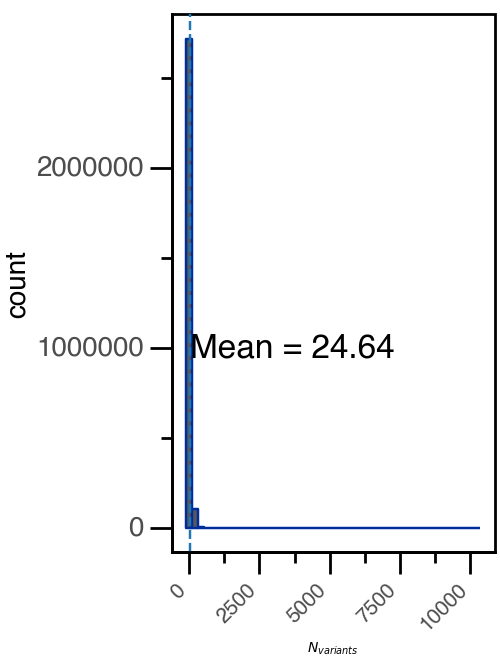

<Figure Size: (250 x 333)>

In [11]:
data = dataset.toPandas()

# Plotting parameters
mean_val = data["locusSize"].mean()

p = (
    p9.ggplot(data=data, mapping=p9.aes(x="locusSize"))
    + p9.geom_histogram(bins=50, color=OpenTargetsTheme.categorical_dark_colors[1])
    + p9.labs(x=r"$N_{variants}$")
    + p9.geom_vline(xintercept=mean_val, color="#1f77b4", linetype="dashed", size=0.5, show_legend=True)
    + OpenTargetsTheme.categorical_theme(REM=5)
    + p9.annotate(
        "text",
        x=mean_val,
        y=1000_000,
        label=f"Mean = {mean_val:.2f}",
        ha="left",
        size=12,
        color="black",
        fontweight="bold",
    )
)
p.save("plots/01.3_credible_set_size_overall.jpg", dpi=300, bbox_inches="tight")
p


## Distribution of credible set study types

The study types were derived from the `studyIndex.studyType` column and enhanced by the `studyLocus.isTransQtl` column.


In [9]:
aggr_stats = aggregated_statistics(dataset, group_columns=["studyType"], agg_column="locusSize").show()


+----------+-------+------------------+------------------+-----+---+
| studyType|  count|              mean|            stddev|  max|min|
+----------+-------+------------------+------------------+-----+---+
|      eqtl|1349478|24.735926039550108| 74.83189536874572| 4136|  1|
|      gwas| 789453|24.610909072484365|105.26355676548235|10248|  1|
|     tuqtl| 384852| 22.17207913691497| 58.33121790494406| 4042|  1|
|      sqtl| 223500|21.606331096196868|48.224814394402785| 3715|  1|
|    sceqtl|  52744|60.795066737448806| 245.0659042400854| 4612|  1|
|trans-pqtl|  17678|17.961081570313382| 80.82612119275363| 2848|  1|
|  cis-pqtl|  16053| 7.160966797483336| 22.28840766484776| 1059|  1|
+----------+-------+------------------+------------------+-----+---+



/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning:

Saving 2.5 x 3.3333333333333335 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning:

Filename: plots/01.3_credible_set_size_boxplot.jpg

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning:

Saving 2.5 x 3.3333333333333335 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning:

Filename: plots/01.3_credible_set_size_by_study_type.jpg



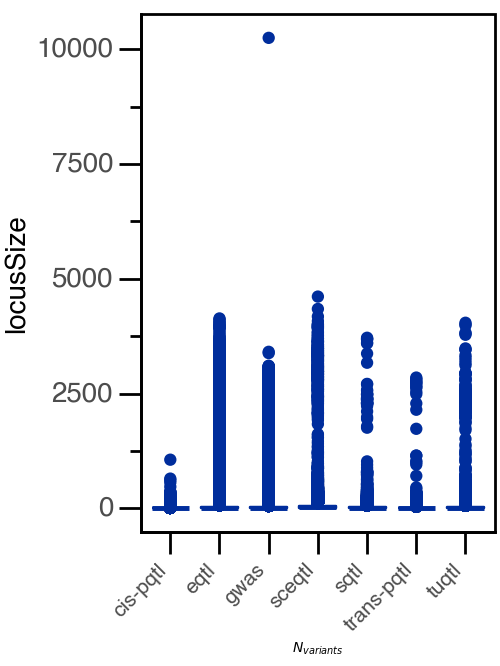

<Figure Size: (250 x 333)>

In [15]:
data = dataset.toPandas()

# Plotting parameters

p = (
    p9.ggplot(data=data, mapping=p9.aes(y="locusSize", x="studyType"))
    + p9.geom_boxplot(color=OpenTargetsTheme.categorical_dark_colors[1])
    + p9.labs(x=r"$N_{variants}$")
    + p9.geom_vline(xintercept=mean_val, color="#1f77b4", linetype="dashed", size=0.5, show_legend=True)
    + OpenTargetsTheme.categorical_theme(REM=5)
)
p.save("plots/01.3_credible_set_size_boxplot.jpg", dpi=300, bbox_inches="tight")

p.save("plots/01.3_credible_set_size_by_study_type.jpg", dpi=300, bbox_inches="tight")
p


## See the outliers

Compute the 99% quantile for the credible set size and filter the dataset


In [ ]:
Q99 = (
    data.toPandas()
    .groupby("studyType")["locusSize"]
    .quantile(0.99)
    .reset_index()
    .rename(columns={"locusSize": "credibleSetSizeQ95"})
)
Q99


,studyType,credibleSetSizeQ95
0,cis-pqtl,90.00
1,eqtl,182.00
2,gwas,229.00
3,sceqtl,449.57
4,sqtl,159.00
5,trans-pqtl,159.23
6,tuqtl,160.00


### Check the cutoff > 5k


In [10]:
from pyspark.sql import functions as f

dataset_maf.df.filter(f.col("locusStatistics.locusSize") > 5000).select(
    "studyId", "studyStatistics.studyType", "locusStatistics.locusSize"
).show(truncate=False)


+-----------------------+---------+---------+
|studyId                |studyType|locusSize|
+-----------------------+---------+---------+
|FINNGEN_R12_I9_CVD_HARD|gwas     |10248    |
+-----------------------+---------+---------+

